<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/ms_graphrag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --upgrade --quiet langchain-community pandas langchain-experimental langchain-openai neo4j graphdatascience tiktoken retry seaborn matplotlib
# https://github.com/tomasonjo/blogs/blob/master/llm/ms_graphrag.ipynb


# GraphRAG with Neo4j and LangChain: Constructing the Graph
## Combine text extraction, network analysis, and LLM prompting and summarization for improved RAG accuracy

I am always intrigued by new approaches to implementing Retrieval-Augmented Generation (RAG) over graphs, often called GraphRAG. However, it seems that everyone has a different implementation in mind when they hear the term GraphRAG. In this blog post, we will dive deep into the “From Local to Global GraphRAG” article and implementation by Microsoft researchers. We will cover the knowledge graph construction and summarization part and leave the retrievers for the next blog post. The researchers were so kind as to provide us with the code repository, and they have a [project page](https://www.microsoft.com/en-us/research/project/graphrag/) as well.

The approach taken in the article mentioned above is quite interesting. As far as I understand, it involves using a knowledge graph as a step in the pipeline for condensing and combining information from multiple sources. Extracting entities and relationships from text is nothing new. However, the authors introduce a novel (at least to me) idea of summarizing condensed graph structure and information back as natural language text. The pipeline begins with input text from documents, which are processed to generate a graph. The graph is then converted back into natural language text, where the generated text contains condensed information about specific entities or graph communities previously spread across multiple documents.

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*NWkjGfKvWyKJsXfj-HxVjA.png)

At a very high level, the input to the GraphRAG pipeline are source documents containing various information. The documents are processed using an LLM to extract structured information about entities appearing in the papers along with their relationships. This extracted structured information is then used to construct a knowledge graph.

The advantage of using a knowledge graph data representation is that it can quickly and straightforwardly combine information from multiple documents or data sources about particular entities. As mentioned, the knowledge graph is not the only data representation, though. After the knowledge graph has been constructed, they use a combination of graph algorithms and LLM prompting to generate natural language summaries of communities of entities found in the knowledge graph.

These summaries then contain condensed information spreading across multiple data sources and documents for particular entities and communities.

For a more detailed understanding of the pipeline, we can refer to the step-by-step description provided in the original paper.

![title](https://miro.medium.com/v2/resize:fit:942/format:webp/1*xn10XHns9xQ1WLQxEaSA7w.png)

Following is a high-level summary of the pipeline that we will use to reproduce their approach using Neo4j and LangChain.

* Indexing — Graph Generation
Source Documents to Text Chunks: Source documents are split into smaller text chunks for processing.
* Text Chunks to Element Instances: Each text chunk is analyzed to extract entities and relationships, producing a list of tuples representing these elements.
* Element Instances to Element Summaries: Extracted entities and relationships are summarized by the LLM into descriptive text blocks for each element.
* Element Summaries to Graph Communities: These entity summaries form a graph, which is then partitioned into communities using algorithms like Leiden for hierarchical structure.
* Graph Communities to Community Summaries: Summaries of each community are generated with the LLM to understand the dataset’s global topical structure and semantics.

#### Retrieval — Answering

* Community Summaries to Global Answers: Community summaries are used to answer a user query by generating intermediate answers, which are then aggregated into a final global answer.
Note that my implementation was done before their code was available, so there might be slight differences in the underlying approach or LLM prompts being used. I’ll try to explain those differences as we go along.

### Setting Up the Neo4j Environment
We will use Neo4j as the underlying graph store. The easiest way to get started is to use a free instance of Neo4j Sandbox, which offers cloud instances of the Neo4j database with the Graph Data Science plugin installed. Alternatively, you can set up a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance. If you are using a local version, make sure to install both APOC and GDS plugins. For production setups, you can use the paid, managed AuraDS (Data Science) instance, which provides the GDS plugin.

We start by creating a Neo4jGraph instance, which is the convenience wrapper we added to LangChain:

In [1]:
#instantiate neo4j instance.
from langchain_neo4j import Neo4jGraph
graph = Neo4jGraph()

### Dataset
We will use a news article dataset I created some time ago using Diffbot’s API. I have uploaded it to my GitHub for easier reuse:

In [2]:
import pandas as pd
import tiktoken


def num_tokens_from_string(string: str, model: str = "gpt-4o") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens


news = pd.read_csv(
    "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/news_articles.csv", nrows=20
)
news["tokens"] = [
    num_tokens_from_string(f"{row['title']} {row['text']}")
    for i, row in news.iterrows()
]
# news.head(5)
news = news[3:9]

We have the title and text of the articles available, along with their publishing date and token count using the tiktoken library.

### Text Chunking
The text chunking step is crucial and significantly impacts downstream results. The paper authors found that using smaller text chunks results in extracting more entities overall.

![title](https://miro.medium.com/v2/resize:fit:1120/format:webp/1*9HdF1xQ6Tm6dazOQBFvSvg.png)

As you can see, using text chunks of 2,400 tokens results in fewer extracted entities than when they used 600 tokens. Additionally, they identified that LLMs might not extract all entities on the first run. In that case, they introduce a heuristics to perform the extraction multiple times. We will talk about that more in the next section.

However, there are always trade-offs. Using smaller text chunks can result in losing the context and coreferences of specific entities spread across the documents. For example, if a document mentions “John” and “he” in separate sentences, breaking the text into smaller chunks might make it unclear that “he” refers to John. Some of the coreference issues can be solved using an overlap text chunking strategy, but not all of them.

Let’s examine the size of our article texts:

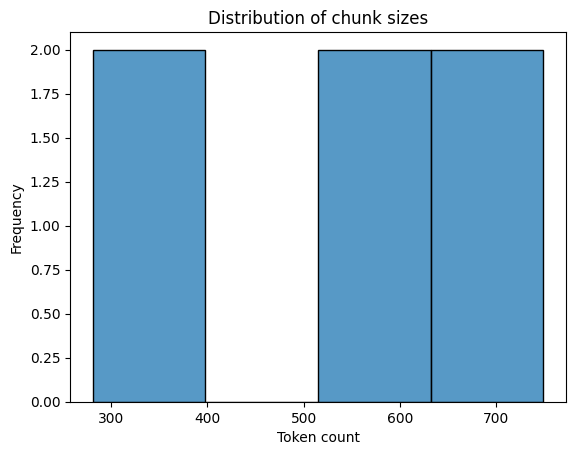

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(news["tokens"], kde=False)
plt.title('Distribution of chunk sizes')
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.show()

The distribution of article token counts is approximately normal, with a peak of around 400 tokens. The frequency of chunks gradually increases up to this peak, then decreases symmetrically, indicating most text chunks are near the 400-token mark.

Due to this distribution, we will not perform any text chunking here to avoid coreference issues. By default, the GraphRAG project uses chunk sizes of 300 tokens with 100 tokens of overlap.

### Extracting Nodes and Relationships
The next step is constructing knowledge from text chunks. For this use case, we use an LLM to extract structured information in the form of nodes and relationships from the text. You can examine the LLM prompt the authors used in the paper. They have LLM prompts where we can predefine node labels if needed, but by default, that’s optional. Additionally, the extracted relationships in the original documentation don’t really have a type, only a description. I imagine the reason behind this choice is to allow the LLM to extract and retain richer and more nuanced information as relationships. But it’s difficult to have a clean knowledge graph with no relationship-type specifications (the descriptions could go into a property).

In our implementation, we will use the LLMGraphTransformer, which is available in the LangChain library. Instead of using pure prompt engineering, as the implementation in the article paper does, the LLMGraphTransformer uses the built-in function calling support to extract structured information (structured output LLMs in LangChain). You can inspect the system prompt:

In [4]:
#Load LLM
from langchain_experimental.llms.ollama_functions import OllamaFunctions
# from ollama_functions import OllamaFunctions
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_ollama import OllamaEmbeddings, ChatOllama

llm_model="mistral:7b-instruct-v0.3-q8_0" #mistral:7b-instruct-v0.3-q8_0, llama3.1:8b-instruct-q8_0, llama3.2:3b-instruct-fp16 llama3.1:8b-instruct-q5_K_M

# llm = OllamaFunctions(model=llm_model, temperature=0, format="json")
llm = ChatOllama(model=llm_model, temperature=0)

llm_transformer = LLMGraphTransformer(
    llm=llm,
    node_properties=["description"],
    relationship_properties=["description"]
)

In [5]:
from typing import List
from langchain_community.graphs.graph_document import GraphDocument
from langchain_core.documents import Document
from langchain.text_splitter import TokenTextSplitter, RecursiveCharacterTextSplitter

def process_text(text: str) -> List[GraphDocument]:
    doc = Document(page_content=text)
    # print(doc)
    # text_splitter = RecursiveCharacterTextSplitter(chunk_size=50, chunk_overlap=10)
    # doc = text_splitter.split_documents(documents=raw_doc)
    return llm_transformer.convert_to_graph_documents([doc])

In this example, we use GPT-4o for graph extraction. The authors specifically instruct the LLM to extract entities and relationships and their descriptions. With the LangChain implementation, you can use the node_propertiesand relationship_propertiesattributes to specify which node or relationship properties you want the LLM to extract.

The difference with the LLMGraphTransformer implementation is that all node or relationship properties are optional, so not all nodes will have the descriptionproperty. If we wanted, we could define a custom extraction to have a mandatory descriptionproperty, but we will skip that in this implementation.

We will parallelize the requests to make the graph extraction faster and store results to Neo4j:

In [6]:
from neo4j import GraphDatabase, Driver
import os

# clear before adding the same source
driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
    )

def clear_database(tx):
    tx.run("""
        MATCH (n)
        DETACH DELETE n
    """)    

with driver.session() as session:
    session.execute_write(clear_database)


In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

MAX_WORKERS = 1
NUM_ARTICLES = 6 #2000
graph_documents = []

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submitting all tasks and creating a list of future objects
    futures = [
        executor.submit(process_text, f"{row['title']} {row['text']}")
        for i, row in news.head(NUM_ARTICLES).iterrows()
    ]

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        graph_document = future.result()
        graph_documents.extend(graph_document)

graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

page_content='Epic’s latest tool can animate hyperrealistic MetaHumans with an iPhone Today, Epic is releasing a new tool designed to capture an actor’s facial performance using a device as simple as an iPhone and apply it to a hyperrealistic “MetaHuman” in the Unreal Engine in “minutes.” The feature, dubbed MetaHuman Animator, was detailed at the Game Developers Conference in March but is now available for developers to try out for themselves. Epic has also released a new video today produced by one of its internal teams to show what the tool is capable of.
While Epic’s short film shows off some impressively subtle facial animation, the big benefit the company is emphasizing is the speed with which MetaHuman Animator produces results. “The animation is produced locally using GPU hardware, with the final animation available in minutes,” the company’s press release reads. That has the potential to not just save a studio money by making performance capture more efficient but also, Epic a

Processing documents:   0%|          | 0/6 [00:00<?, ?it/s]

Processing documents:  17%|█▋        | 1/6 [04:54<24:34, 294.97s/it]

page_content='EU to Ban Huawei, ZTE from Internal Commission Networks The European Commission is planning to ban equipment from Chinese vendors Huawei Technologies Co. and ZTE Corp. from its own internal telecommunications networks, people familiar with the matter said.
The ban comes ahead of an anticipated update to the European Union’s guidance on 5G mobile networks within the bloc that’s expected to more forcefully encourage members to phase out equipment from the companies, which it considers high risk, the people said, asking not to be identified because the plan isn’t yet public.
As the relationship between the US and its allies and China has deteriorated, countries have blocked Chinese technology from their core telecommunications networks because of spying concerns. The move is similar to the commission’s decision to block its staff from using TikTok Inc. over security concerns related to the social-media app’s data-collection practices.
Read More: TikTok Banned From EU Commiss

Processing documents:  33%|███▎      | 2/6 [05:00<08:18, 124.73s/it]

page_content='Arsenal have Rice bid rejected, new Premier League fixtures released, Man United out of Harry Kane race, Chelsea reject Mason Mount bid Jude Bellingham has also insisted his move to Real Madrid had nothing to do with money, as he explained how his transfer was wrapped up so quickly.
“Money is not a thing for me,” he said.
“I dont think about money at all when I make these kinds of decisions. I never have and I never will. I play the game purely out of love.
“I spoke with people from Real Madrid when I was given permission by Borussia Dortmund and I love the feeling I got from the club. I couldn’t hide it. I told them straight away what I felt and after that happened on Monday it all happened quickly.”
He also opened up on how he was given the No.5 shirt, which was worn by defender Jesus Vallejo last season, and what it means to him to have Zidane’s old number on his back.
“For a start I’d like to thank Jesus Vallejo for letting me wear the No.5,” he explained.
“I contacte

Processing documents:  50%|█████     | 3/6 [05:06<03:31, 70.44s/it] 

page_content='Ryanair sacks chief pilot over sexual misconduct claims Reuters
Ryanair has sacked its chief pilot after an investigation into his alleged sexual harassment of female colleagues.
The airline told staff that he had been fired for "a pattern of repeated inappropriate and unacceptable behaviour towards a number of female pilots".
The chief pilot, named in reports as Aidan Murray was appointed in 2020 and had been with the airline for 28 years.
Ryanair declined to comment "on queries relating to individual employees".
According to The Independent, Mr Murray allegedly harassed nine junior colleagues, including sending text messages to some with comments on their bodies.
Mr Murray, 58, is also accused of altering flight rosters to fly with certain female pilots.
In a note to staff, Ryanair's chief people officer, Darrell Hughes, said Mr Murray's employment had been "terminated with immediate effect".
An investigation found his behaviour "was in breach of our anti-harassment pol

Processing documents:  67%|██████▋   | 4/6 [05:11<01:29, 44.70s/it]

page_content='KeyBank’s American Fork Branch Celebrates One Year Anniversary CLEVELAND, UT / ACCESSWIRE / June 15, 2023 / KeyBank recently commemorated the one-year anniversary of its American Fork branch - the company's first new branch in the Western half of the U.S. in more than a decade. The celebration included a networking event with the branch's business clients and the American Fork Chamber of Commerce, as well as a $10,000 donation to the Five.12 Foundation.
"We've had a great first year in American Fork," said Drew Yergensen, KeyBank Utah market president and commercial banking leader. "We have really enjoyed meeting and working more closely with our new neighbors, clients and community partners, and we look forward to strengthening those relationships even further in the coming years."
The American Fork branch highlights KeyBank's state-of-the-art financial wellness center model, which is staffed with financial wellness consultants rather than a traditional teller line. All 

Processing documents:  83%|████████▎ | 5/6 [05:16<00:30, 30.50s/it]

page_content='Vivo X90s Officially Teased, Tipped to Run on New MediaTek Dimensity 9200+ SoC Vivo X90s has been teased by Jia Jingdong, Vivo's Vice President and General Manager of Product Strategy via Weibo on Thursday. The new smartphone has a design similar to its Vivo X90 series siblings — Vivo X90 and Vivo X90 Pro. The Vivo X90s is shown to have a Zeiss-tuned triple rear camera unit. The upcoming model is expected to retain the key specification of the Vivo X90. Meanwhile, Chinese tipsters have leaked the specifications of the upcoming handset. The Vivo X90s is said to run on MediaTek Dimensity 9200+ SoC and could be offered in four different colour options.
Jia Jingdong posted an image of the Vivo X90s on the Chinese microblogging platform providing us a glimpse of the design from the rear. The render shows the handset in a white finish with rounded corners. The image suggests Zeiss branded triple rear cameras on the rear panel along with an LED flash. It seems to have a glass ba

Processing documents: 100%|██████████| 6/6 [05:23<00:00, 53.95s/it]


In [10]:
#load text instead
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import TokenTextSplitter, RecursiveCharacterTextSplitter

loader = TextLoader(file_path="dummytext.txt")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100) #or TokenTextSplitter
documents = text_splitter.split_documents(documents=docs)

graph_documents = llm_transformer.convert_to_graph_documents(documents); 
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)
#see https://python.langchain.com/docs/how_to/extraction_long_text/ for more efficient parallel runs

In this example, we extract graph information from 2,000 articles and store results to Neo4j. We have extracted around 13,000 entities and 16,000 relationships. Here is an example of an extracted document in the graph.


![title](https://miro.medium.com/v2/resize:fit:952/format:webp/1*pj-V-XHmVaJE5SsOtvqOqw.png)

It takes about 35 (+/- 5) minutes to complete extraction and costs about $30 with GPT-4o.

In this step, the authors introduce heuristics to decide whether to extract graph information in more than one pass. For simplicity’s sake, we will only do one pass. However, if we wanted to do multiple passes, we could put the first extraction results as conversational history and simply [instruct the LLM that many entities are missing](https://github.com/microsoft/graphrag/blob/main/graphrag/index/graph/extractors/claims/prompts.py#L60), and it should extract more, like the GraphRAG authors do.

Previously, I mentioned how vital text chunk size is and how it affects the number of entities extracted. Since we didn’t perform any additional text chunking, we can evaluate the distribution of extracted entities based on text chunk size:

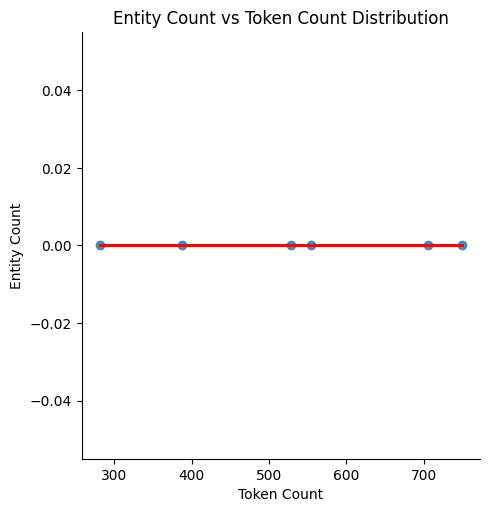

In [8]:
entity_dist = graph.query(
    """
MATCH (d:Document)
RETURN d.text AS text,
       count {(d)-[:MENTIONS]->()} AS entity_count
"""
)
entity_dist_df = pd.DataFrame.from_records(entity_dist)
entity_dist_df["token_count"] = [
    num_tokens_from_string(str(el)) for el in entity_dist_df["text"]
]
# Scatter plot with regression line
sns.lmplot(
    x="token_count", y="entity_count", data=entity_dist_df, line_kws={"color": "red"}
)
plt.title("Entity Count vs Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Entity Count")
plt.show()


The scatter plot shows that while there is a positive trend, indicated by the red line, the relationship is sublinear. Most data points cluster at lower entity counts, even as token counts increase. This indicates that the number of entities extracted does not scale proportionally with the size of the text chunks. Although some outliers exist, the general pattern shows that higher token counts do not consistently lead to higher entity counts. This validates the authors’ finding that lower text chunk sizes will extract more information.

I also thought it would be interesting to inspect the node degree distributions of the constructed graph. The following code retrieves and visualizes node degree distributions:

In [9]:
import numpy as np

degree_dist = graph.query(
    """
MATCH (e:__Entity__)
RETURN count {(e)-[:!MENTIONS]-()} AS node_degree
"""
)
degree_dist_df = pd.DataFrame.from_records(degree_dist)

# Calculate mean and median
mean_degree = np.mean(degree_dist_df['node_degree'])
percentiles = np.percentile(degree_dist_df['node_degree'], [25, 50, 75, 90])
# Create a histogram with a logarithmic scale
plt.figure(figsize=(12, 6))
sns.histplot(degree_dist_df['node_degree'], bins=50, kde=False, color='blue')
# Use a logarithmic scale for the x-axis
plt.yscale('log')
# Adding labels and title
plt.xlabel('Node Degree')
plt.ylabel('Count (log scale)')
plt.title('Node Degree Distribution')
# Add mean, median, and percentile lines
plt.axvline(mean_degree, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_degree:.2f}')
plt.axvline(percentiles[0], color='purple', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentiles[0]:.2f}')
plt.axvline(percentiles[1], color='orange', linestyle='dashed', linewidth=1, label=f'50th Percentile: {percentiles[1]:.2f}')
plt.axvline(percentiles[2], color='yellow', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentiles[2]:.2f}')
plt.axvline(percentiles[3], color='brown', linestyle='dashed', linewidth=1, label=f'90th Percentile: {percentiles[3]:.2f}')
# Add legend
plt.legend()
# Show the plot
plt.show()

KeyError: 'node_degree'

The node degree distribution follows a power-law pattern, indicating most nodes have very few connections while a few nodes are highly connected. The mean degree is 2.45, and the median is 1.00, showing that more than half the nodes have only one connection. Most nodes (75 percent) have two or fewer connections, and 90 percent have five or fewer. This distribution is typical of many real-world networks, where a small number of hubs have many connections, and most nodes have few.

Since both node and relationship descriptions are not mandatory properties, we will also examine how many were extracted:

In [85]:
graph.query("""
MATCH (n:`__Entity__`)
RETURN "node" AS type,
       count(*) AS total_count,
       count(n.description) AS non_null_descriptions
UNION ALL
MATCH (n)-[r:!MENTIONS]->()
RETURN "relationship" AS type,
       count(*) AS total_count,
       count(r.description) AS non_null_descriptions
""")

[{'type': 'node', 'total_count': 40, 'non_null_descriptions': 20},
 {'type': 'relationship', 'total_count': 5, 'non_null_descriptions': 0}]

The results show that 5,926 nodes out of 12,994 (45.6 percent) have the description property. On the other hand, only 5,569 relationships out of 15,921 (35 percent) have such a property.

Note that due to the probabilistic nature of LLMs, the numbers can vary on different runs and different source data, LLMs, and prompts.

### Entity Resolution
Entity resolution (de-duplication) is crucial when constructing knowledge graphs because it ensures that each entity is uniquely and accurately represented, preventing duplicates and merging records that refer to the same real-world entity. This process is essential for maintaining data integrity and consistency within the graph. Without entity resolution, knowledge graphs would suffer from fragmented and inconsistent data, leading to errors and unreliable insights.

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*rlWiW1sWlixDTaY0.png)

This image demonstrates how a single real-world entity might appear under slightly different names in different documents and, consequently, in our graph.

Moreover, sparse data becomes a significant issue without entity resolution. Incomplete or partial data from various sources can result in scattered and disconnected pieces of information, making it difficult to form a coherent and comprehensive understanding of entities. Accurate entity resolution addresses this by consolidating data, filling in gaps, and creating a unified view of each entity.

Overall, entity resolution enhances the efficiency of data retrieval and integration, providing a cohesive view of information across different sources. It ultimately enables more effective question-answering based on a reliable and complete knowledge graph.

Unfortunately, the authors of the GraphRAG paper did not include any entity resolution code in their repo, although they mention it in their paper. One reason for leaving this code out could be that it is tough to implement a robust and well-performing entity resolution for any given domain. You can implement custom heuristics for different nodes when dealing with pre-defined types of nodes (when they aren’t predefined, they aren’t consistent enough, like company, organization, business, etc.). However, if the node labels or types aren’t known in advance, as in our case, this becomes an even harder problem. Nonetheless, we will implement a version of entity resolution in our project here, combining text embeddings and graph algorithms with word distance and LLMs.

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*KlLF01Imn7RlyuSWYkwnqw.png)

Our process for entity resolution involves the following steps:

1. Entities in the graph — Start with all entities within the graph.
2. K-nearest graph — Construct a k-nearest neighbor graph, connecting similar entities based on text embeddings.
3. Weakly Connected Components — Identify weakly connected components in the k-nearest graph, grouping entities that are likely to be similar. Add a word distance filtering step after these components have been identified.
4. LLM evaluation — Use an LLM to evaluate these components and decide whether the entities within each component should be merged, resulting in a final decision on entity resolution (for example, merging ‘Silicon Valley Bank’ and ‘Silicon_Valley_Bank’ while rejecting the merge for different dates like ‘September 16, 2023’ and ‘September 2, 2023’).

We begin by calculating text embeddings for the name and description properties of entities. We can use the from_existing_graph method in the Neo4jVector integration in LangChain to achieve this:

In [86]:
# from langchain_community.vectorstores import Neo4jVector
# from langchain_openai import OpenAIEmbeddings

# vector = Neo4jVector.from_existing_graph(
#     OpenAIEmbeddings(),
#     node_label='__Entity__',
#     text_node_properties=['id', 'description'],
#     embedding_node_property='embedding'
# )
from langchain_community.vectorstores import Neo4jVector
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars

embeddings = OllamaEmbeddings(
    model="mxbai-embed-large",
)

vector = Neo4jVector.from_existing_graph(
    embeddings,
    # search_type="hybrid",
    node_label='__Entity__',
    text_node_properties=['id', 'description'],
    embedding_node_property="embedding"
)

# vector_retriever = vector_index.as_retriever()

We can use these embeddings to find potential candidates that are similar based on the cosine distance of these embeddings. We will use graph algorithms available in the Graph Data Science (GDS) library; therefore, we can use the GDS Python client for ease of use in a Pythonic way:

In [87]:
import os
from graphdatascience import GraphDataScience
# https://neo4j.com/docs/graph-data-science/current/installation/installation-docker/
# project graph

gds = GraphDataScience(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

If you are not familiar with the GDS library, we first have to project an in-memory graph before we can execute any graph algorithms.

![title](https://miro.medium.com/v2/resize:fit:1268/format:webp/1*YdEljYtG2ddd7DrrlzS6yg.png)

First, the Neo4j stored graph is projected into an in-memory graph for faster processing and analysis. Next, a graph algorithm is executed on the in-memory graph. Optionally, the algorithm’s results can be stored back into the Neo4j database. Learn more about it in the documentation.

To create the k-nearest neighbor graph, we will project all entities along with their text embeddings:

In [91]:
G, result = gds.graph.project(
    "entities2",                   #  Graph name
    "__Entity__",                 #  Node projection
    "*",                          #  Relationship projection
    nodeProperties=["embedding"]  #  Configuration parameters
)

Now that the graph is projected under the entities name, we can execute graph algorithms. We will begin by constructing a k-nearest graph. The two most important parameters influencing how sparse or dense the k-nearest graph will be are similarityCutoff and topK. The topKis the number of neighbors to find for each node, with a minimum value of 1. The similarity cutoff filters out relationships with similarity below this threshold. Here, we will use a default topKof 10 and a relatively high similarity cutoff of 0.95. Using a high similarity cutoff, such as 0.95, ensures that only highly similar pairs are considered matches, minimizing false positives and improving accuracy.

![title](https://miro.medium.com/v2/resize:fit:942/format:webp/1*Wt_9Tj9P_FsU7w1IvpO39g.png)

Since we want to store the results back to the projected in-memory graph instead of the knowledge graph, we will use the mutate mode of the algorithm:

In [92]:
similarity_threshold = 0.95

gds.knn.mutate(
  G,
  nodeProperties=['embedding'],
  mutateRelationshipType= 'SIMILAR',
  mutateProperty= 'score',
  similarityCutoff=similarity_threshold
)

ranIterations                                                             3
nodePairsConsidered                                                    9907
didConverge                                                            True
preProcessingMillis                                                       0
computeMillis                                                            28
mutateMillis                                                              5
postProcessingMillis                                                      0
nodesCompared                                                            40
relationshipsWritten                                                      0
similarityDistribution    {'min': 0.0, 'p5': 0.0, 'max': 5.0872912848509...
configuration             {'mutateProperty': 'score', 'jobId': '418c1bc5...
Name: 0, dtype: object

The next step is to identify groups of entities that are connected with the newly inferred similarity relationships. Identifying groups of connected nodes is a frequent process in network analysis, often called community detection or clustering, which involves finding subgroups of densely connected nodes. In this example, we will use the Weakly Connected Components algorithm, which helps us find parts of a graph where all nodes are connected, even if we ignore the direction of the connections.

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ZhawRXqvoZ6EuuUzacCf7A.png)

We use the algorithm’s write mode to store the results back to the database (stored graph):

In [93]:
gds.wcc.write(
    G,
    writeProperty="wcc",
    relationshipTypes=["SIMILAR"]
)

writeMillis                                                             50
nodePropertiesWritten                                                   40
componentCount                                                          40
componentDistribution    {'min': 1, 'p5': 1, 'max': 1, 'p999': 1, 'p99'...
postProcessingMillis                                                     3
preProcessingMillis                                                      0
computeMillis                                                            0
configuration            {'writeProperty': 'wcc', 'jobId': 'dff26014-73...
Name: 0, dtype: object

Text embedding comparison helps find potential duplicates, but it is only part of the entity resolution process. For example, Google and Apple are very close in the embedding space (0.96 cosine similarity using the ada-002 embedding model). The same goes for BMW and Mercedes Benz (0.97 cosine similarity). High text embedding similarity is a good start, but we can improve it. Therefore, we will add an additional filter allowing only pairs of words with a text distance of three or fewer (meaning that only the characters can be changed):

In [94]:
word_edit_distance = 3
potential_duplicate_candidates = graph.query(
    """MATCH (e:`__Entity__`)
    WHERE size(e.id) > 4 // longer than 4 characters
    WITH e.wcc AS community, collect(e) AS nodes, count(*) AS count
    WHERE count > 1
    UNWIND nodes AS node
    // Add text distance
    WITH distinct
      [n IN nodes WHERE apoc.text.distance(toLower(node.id), toLower(n.id)) < $distance | n.id] AS intermediate_results
    WHERE size(intermediate_results) > 1
    WITH collect(intermediate_results) AS results
    // combine groups together if they share elements
    UNWIND range(0, size(results)-1, 1) as index
    WITH results, index, results[index] as result
    WITH apoc.coll.sort(reduce(acc = result, index2 IN range(0, size(results)-1, 1) |
            CASE WHEN index <> index2 AND
                size(apoc.coll.intersection(acc, results[index2])) > 0
                THEN apoc.coll.union(acc, results[index2])
                ELSE acc
            END
    )) as combinedResult
    WITH distinct(combinedResult) as combinedResult
    // extra filtering
    WITH collect(combinedResult) as allCombinedResults
    UNWIND range(0, size(allCombinedResults)-1, 1) as combinedResultIndex
    WITH allCombinedResults[combinedResultIndex] as combinedResult, combinedResultIndex, allCombinedResults
    WHERE NOT any(x IN range(0,size(allCombinedResults)-1,1)
        WHERE x <> combinedResultIndex
        AND apoc.coll.containsAll(allCombinedResults[x], combinedResult)
    )
    RETURN combinedResult
    """, params={'distance': word_edit_distance})
potential_duplicate_candidates[:5]

[]

This Cypher statement is slightly more involved, and its interpretation is beyond the scope of this blog post. You can always ask an LLM to interpret it.

Additionally, the word distance cutoff could be a function of the length of the word instead of a single number and the implementation could be more scalable.

What is important is that it outputs groups of potential entities we might want to merge.

As you can see, our resolution approach works better for some node types than others. Based on a quick examination, it seems to work better for people and organizations, while it’s pretty bad for dates. If we used predefined node types, we could prepare different heuristics for various node types. In this example, we do not have predefined node labels, so we will turn to an LLM to make the final decision about whether entities should be merged or not.

First, we need to formulate the LLM prompt to effectively guide and inform the final decision regarding the merging of the nodes:

In [95]:
system_prompt = """You are a data processing assistant. Your task is to identify duplicate entities in a list and decide which of them should be merged.
The entities might be slightly different in format or content, but essentially refer to the same thing. Use your analytical skills to determine duplicates.

Here are the rules for identifying duplicates:
1. Entities with minor typographical differences should be considered duplicates.
2. Entities with different formats but the same content should be considered duplicates.
3. Entities that refer to the same real-world object or concept, even if described differently, should be considered duplicates.
4. If it refers to different numbers, dates, or products, do not merge results
"""
user_template = """
Here is the list of entities to process:
{entities}

Please identify duplicates, merge them, and provide the merged list.
"""

I always like to use with_structured_output method in LangChain when expecting structured data output to avoid having to parse the outputs manually.

Here, we will define the output as a list of lists, where each inner list contains the entities that should be merged. This structure is used to handle scenarios where, for example, the input might be [Sony, Sony Inc, Google, Google Inc]. In such cases, you would want to merge “Sony” and “Sony Inc” separately from “Google” and “Google Inc.”

In [98]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate
from retry import retry

class DuplicateEntities(BaseModel):
    entities: List[str] = Field(
        description="Entities that represent the same object or real-world entity and should be merged"
    )


class Disambiguate(BaseModel):
    merge_entities: Optional[List[DuplicateEntities]] = Field(
        description="Lists of entities that represent the same object or real-world entity and should be merged"
    )


extraction_llm = OllamaFunctions(model=llm_model).with_structured_output(
    Disambiguate
)

extraction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt,
        ),
        (
            "human",
            user_template,
        ),
    ]
)

Next, we integrate the LLM prompt with the structured output to create a chain using LangChain Expression Language (LCEL) syntax and encapsulate it within a disambiguate function.

In [99]:
extraction_chain = extraction_prompt | extraction_llm

@retry(tries=3, delay=2)
def entity_resolution(entities: List[str]) -> Optional[List[str]]:
    return [
        el.entities
        for el in extraction_chain.invoke({"entities": entities}).merge_entities
    ]



In [100]:
entity_resolution(['Star Ocean The Second Story R', 'Star Ocean: The Second Story R'])

AttributeError: type object 'Disambiguate' has no attribute 'model_construct'

In [ ]:
entity_resolution({"entities": ['December 16, 2023',
   'December 2, 2023',
   'December 23, 2023',
   'December 26, 2023',
   'December 30, 2023',
   'December 5, 2023',
   'December 9, 2023']})

AttributeError: type object 'Disambiguate' has no attribute 'model_construct'

We need to run all potential candidate nodes through the entity_resolution function to decide whether they should be merged. To speed up the process, we will again parallelize the LLM calls:

In [ ]:
merged_entities = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submitting all tasks and creating a list of future objects
    futures = [
        executor.submit(entity_resolution, el['combinedResult'])
        for el in potential_duplicate_candidates
    ]

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        to_merge = future.result()
        if to_merge:
            merged_entities.extend(to_merge)

In [ ]:
merged_entities[:10]

The final step of entity resolution involves taking the results from the entity_resolution LLM and writing them back to the database by merging the specified nodes:



In [ ]:
graph.query("""
UNWIND $data AS candidates
CALL {
  WITH candidates
  MATCH (e:__Entity__) WHERE e.id IN candidates
  RETURN collect(e) AS nodes
}
CALL apoc.refactor.mergeNodes(nodes, {properties: {
    `.*`: 'discard'
}})
YIELD node
RETURN count(*)
""", params={"data": merged_entities})

In [ ]:
G.drop()

This entity resolution is not perfect, but it gives us a starting point upon which we can improve. Additionally, we can improve the logic for determining which entities should be retained.

### Element Summarization
In the next step, the authors perform an element summarization step. Essentially, every node and relationship gets passed through an entity summarization prompt. The authors note the novelty and interest of their approach:

“Overall, our use of rich descriptive text for homogeneous nodes in a potentially noisy graph structure is aligned with both the capabilities of LLMs and the needs of global, query-focused summarization. These qualities also differentiate our graph index from typical knowledge graphs, which rely on concise and consistent knowledge triples (subject, predicate, object) for downstream reasoning tasks.”

The idea is exciting. We still extract subject and object IDs or names from text, which allows us to link relationships to correct entities, even when entities appear across multiple text chunks. However, the relationships aren’t reduced to a single type. Instead, the relationship type is actually a freeform text that allows us to retain richer and more nuanced information.

Additionally, the entity information is summarized using an LLM, allowing us to embed and index this information and entities more efficiently for more accurate retrieval.

One could argue that this richer and more nuanced information could also be retained by adding additional, possibly arbitrary, node and relationship properties. One issue with arbitrary node and relationship properties is that it could be hard to extract the information consistently because the LLM might use different property names or focus on various details on every execution.

Some of these problems could be solved using predefined property names with additional type and description information. In that case, you would need a subject-matter expert to help define those properties, leaving little room for an LLM to extract any vital information outside the predefined descriptions.

It’s an exciting approach to represent richer information in a knowledge graph.

One potential issue with the element summarization step is that it does not scale well since it requires an LLM call for every entity and relationship in the graph. Our graph is relatively tiny with 13,000 nodes and 16,000 relationships. Even for such a small graph, we would require 29,000 LLM calls, and each call would use a couple hundred tokens, making it quite expensive and time-intensive. Therefore, we will avoid this step here. We can still use the description properties extracted during the initial text processing.

### Constructing and Summarizing Communities
The final step in the graph construction and indexing process involves identifying communities within the graph. In this context, a community is a group of nodes that are more densely connected to each other than to the rest of the graph, indicating a higher level of interaction or similarity. The following visualization shows an example of community detection results.

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*l2i3ctl8s6xdR6ul.png)

Once these entity communities are identified with a clustering algorithm, an LLM generates a summary for each community, providing insights into their individual characteristics and relationships.

Again, we use the Graph Data Science library. We start by projecting an in-memory graph. To follow the original article precisely, we will project the graph of entities as an undirected weighted network, where the network represents the number of connections between two entities:

In [ ]:
G, result = gds.graph.project(
    "communities",  #  Graph name
    "__Entity__",  #  Node projection
    {
        "_ALL_": {
            "type": "*",
            "orientation": "UNDIRECTED",
            "properties": {"weight": {"property": "*", "aggregation": "COUNT"}},
        }
    },
)

The authors employed the Leiden algorithm, a hierarchical clustering method, to identify communities within the graph. One advantage of using a hierarchical community detection algorithm is the ability to examine communities at multiple levels of granularity. The authors suggest summarizing all communities at each level, providing a comprehensive understanding of the graph’s structure.

First, we will use the Weakly Connected Components (WCC) algorithm to assess the connectivity of our graph. This algorithm identifies isolated sections within the graph, meaning it detects subsets of nodes or components that are connected to each other but not to the rest of the graph. These components help us understand the fragmentation within the network and identify groups of nodes that are independent from others. WCC is vital for analyzing the overall structure and connectivity of the graph.

In [ ]:
wcc = gds.wcc.stats(G)
print(f"Component count: {wcc['componentCount']}")
print(f"Component distribution: {wcc['componentDistribution']}")

The WCC algorithm results identified 1,119 distinct components. Notably, the largest component comprises 9,109 nodes, common in real-world networks where a single super component coexists with numerous smaller isolated components. The smallest component has one node, and the average component size is about 11.3 nodes.

Next, we will run the Leiden algorithm, which is also available in the GDS library, and enable the includeIntermediateCommunities parameter to return and store communities at all levels. We have also included a relationshipWeightProperty parameter to run the weighted variant of the Leiden algorithm. Using the write mode of the algorithm stores the results as a node property.

In [ ]:
gds.leiden.write(
    G,
    writeProperty="communities",
    includeIntermediateCommunities=True,
    relationshipWeightProperty="weight",
)


The algorithm identified five levels of communities, with the highest (least granular level where communities are largest) having 1,188 communities (as opposed to 1,119 components). Building on this, we will create a distinct node for each community and represent their hierarchical structure as an interconnected graph. Later, we will also store community summaries and other attributes as node properties.

In [ ]:
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:__Community__) REQUIRE c.id IS UNIQUE;")

In [ ]:
graph.query("""
MATCH (e:`__Entity__`)
UNWIND range(0, size(e.communities) - 1 , 1) AS index
CALL {
  WITH e, index
  WITH e, index
  WHERE index = 0
  MERGE (c:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  ON CREATE SET c.level = index
  MERGE (e)-[:IN_COMMUNITY]->(c)
  RETURN count(*) AS count_0
}
CALL {
  WITH e, index
  WITH e, index
  WHERE index > 0
  MERGE (current:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  ON CREATE SET current.level = index
  MERGE (previous:`__Community__` {id: toString(index - 1) + '-' + toString(e.communities[index - 1])})
  ON CREATE SET previous.level = index - 1
  MERGE (previous)-[:IN_COMMUNITY]->(current)
  RETURN count(*) AS count_1
}
RETURN count(*)
""")

The authors also introduce a community rank, indicating the number of distinct text chunks in which the entities within the community appear:

In [ ]:
graph.query("""
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(:__Entity__)<-[:MENTIONS]-(d:Document)
WITH c, count(distinct d) AS rank
SET c.community_rank = rank;
""")

Now let’s examine a sample hierarchical structure with many intermediate communities merging at higher levels. The communities are non-overlapping, meaning that each entity belongs to precisely a single community at each level.
Let’s examine the number of communities and their sizes and different levels in more detail:

In [ ]:
community_size = graph.query(
    """
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(e:__Entity__)
WITH c, count(distinct e) AS entities
RETURN split(c.id, '-')[0] AS level, entities
"""
)
community_size_df = pd.DataFrame.from_records(community_size)
percentiles_data = []
for level in community_size_df["level"].unique():
    subset = community_size_df[community_size_df["level"] == level]["entities"]
    num_communities = len(subset)
    percentiles = np.percentile(subset, [25, 50, 75, 90, 99])
    percentiles_data.append(
        [
            level,
            num_communities,
            percentiles[0],
            percentiles[1],
            percentiles[2],
            percentiles[3],
            percentiles[4],
            max(subset)
        ]
    )

# Create a DataFrame with the percentiles
percentiles_df = pd.DataFrame(
    percentiles_data,
    columns=[
        "Level",
        "Number of communities",
        "25th Percentile",
        "50th Percentile",
        "75th Percentile",
        "90th Percentile",
        "99th Percentile",
        "Max"
    ],
)
percentiles_df


In the original implementation, communities on every level were summarized. In our case, that would be 8,590 communities and, consequently, 8,590 LLM calls. I would argue that depending on the hierarchical community structure, not every level needs to be summarized. For example, the difference between the last and the next-to-last level is only four communities (1,192 vs. 1,188). Therefore, we would be creating a lot of redundant summaries. One solution is to create an implementation that can make a single summary for communities on different levels that don’t change; another one would be to collapse community hierarchies that don’t change.

Also, I am unsure if we want to summarize communities with only one member, as they might not provide much value or information. Here, we will summarize communities on levels 0, 1, and 4. First, we need to retrieve their information from the database:

In [ ]:
community_info = graph.query("""
MATCH (c:`__Community__`)<-[:IN_COMMUNITY*]-(e:__Entity__)
WHERE c.level IN [0,1,4]
WITH c, collect(e ) AS nodes
WHERE size(nodes) > 1
CALL apoc.path.subgraphAll(nodes[0], {
	whitelistNodes:nodes
})
YIELD relationships
RETURN c.id AS communityId,
       [n in nodes | {id: n.id, description: n.description, type: [el in labels(n) WHERE el <> '__Entity__'][0]}] AS nodes,
       [r in relationships | {start: startNode(r).id, type: type(r), end: endNode(r).id, description: r.description}] AS rels
""")

In [ ]:
community_info[5]

Now, we need to prepare an LLM prompt that generates a natural language summarization based on the information provided by the elements of our community. We can take some inspiration from the [prompt the researchers used](https://github.com/microsoft/graphrag/blob/main/graphrag/prompt_tune/template/community_report_summarization.py).

The authors not only summarized communities but also generated findings for each of them. A finding can be defined as concise information regarding a specific event or piece of information. One such example:
```
"summary": "Abila City Park as the central location",
"explanation": "Abila City Park is the central entity in this community, serving as the location for the POK rally. This park is the common link between all other
entities, suggesting its significance in the community. The park's association with the rally could potentially lead to issues such as public disorder or conflict, depending on the
nature of the rally and the reactions it provokes. [records: Entities (5), Relationships (37, 38, 39, 40)]"
```
My intuition suggests that extracting findings with just a single pass might not be as comprehensive as we need, much like extracting entities and relationships.

Furthermore, I have not found any references or examples of their use in their code in either local or global search retrievers. As a result, we’ll refrain from extracting findings in this instance. Or, as academics often put it: This exercise is left to the reader. Additionally, we have also skipped the claims or covariate information extraction, which looks similar to findings at first glance.

The prompt we’ll use to produce the community summaries is fairly straightforward:

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

community_template = """Based on the provided nodes and relationships that belong to the same graph community,
generate a natural language summary of the provided information:
{community_info}

Summary:"""  # noqa: E501

community_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Given an input triples, generate the information summary. No pre-amble.",
        ),
        ("human", community_template),
    ]
)

community_chain = community_prompt | llm | StrOutputParser()

The only thing left is to turn community representations into strings to reduce the number of tokens by avoiding JSON token overhead and wrap the chain as a function:

In [ ]:
def prepare_string(data):
    nodes_str = "Nodes are:\n"
    for node in data['nodes']:
        node_id = node['id']
        node_type = node['type']
        if 'description' in node and node['description']:
            node_description = f", description: {node['description']}"
        else:
            node_description = ""
        nodes_str += f"id: {node_id}, type: {node_type}{node_description}\n"

    rels_str = "Relationships are:\n"
    for rel in data['rels']:
        start = rel['start']
        end = rel['end']
        rel_type = rel['type']
        if 'description' in rel and rel['description']:
            description = f", description: {rel['description']}"
        else:
            description = ""
        rels_str += f"({start})-[:{rel_type}]->({end}){description}\n"

    return nodes_str + "\n" + rels_str

def process_community(community):
    stringify_info = prepare_string(community)
    summary = community_chain.invoke({'community_info': stringify_info})
    return {"community": community['communityId'], "summary": summary}

In [ ]:
print(prepare_string(community_info[3]))

Now we can generate community summaries for the selected levels. Again, we parallelize calls for faster execution:

In [ ]:
summaries = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_community, community): community for community in community_info}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing communities"):
        summaries.append(future.result())

One aspect I didn’t mention is that the authors also address the potential issue of exceeding context size when inputting community information. As graphs expand, the communities can grow significantly as well. In our case, the largest community comprised 545 members. Given that GPT-4o has a context size exceeding 100,000 tokens, we decided to skip this step.

As our final step, we will store the community summaries back to the database:

In [ ]:
# Store summaries
graph.query("""
UNWIND $data AS row
MERGE (c:__Community__ {id:row.community})
SET c.summary = row.summary
""", params={"data": summaries})

The final graph structure:

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*rkgiVH20AuG1X-rMzTipXQ.png)

The graph now contains the original documents, extracted entities and relationships, as well as hierarchical community structure and summaries.

Summary
The authors of the “From Local to Global” paper have done a great job in demonstrating a new approach to GraphRAG. They show how we can combine and summarize information from various documents into a hierarchical knowledge graph structure.

One thing that isn’t explicitly mentioned is that we can also integrate structured data sources in a graph; the input doesn’t have to be limited to unstructured text only.

What I particularly appreciate about their extraction approach is that they capture descriptions for both nodes and relationships. Descriptions allow the LLM to retain more information than reducing everything to just node IDs and relationship types.

Additionally, they demonstrate that a single extraction pass over the text might not capture all relevant information and introduce logic to perform multiple passes if necessary. The authors also present an interesting idea for performing summarizations over graph communities, allowing us to embed and index condensed topical information across multiple data sources.

In the next blog post, we will go over the local and global search retriever implementations and talk about other approaches we could implement based on the given graph structure.